### Домашнее задание № 11
### Козел А.Г.  30.10.2022   v.1 

В данной задаче нам представлены данные в которых ключевое поле — это то, просрочит ли клиент микро-финансовой организации выплату более чем на 60 дней или нет. 
Нам нужно построить модель, которая по входным данным предсказывала бы с максимальной точностью ключе-вой параметр. 
Основной параметр это delinq60plus. Остальные парамет-ры интуитивно понятны из таблиц.
### Цель

Построить модель машинного обучения для предсказания вероятности того, что клиент уйдет в просрочку более 60 дней.

### Задача
осуществить корректную загрузку данных
осуществить разведывательный анализ данных:
- разбить выборку на обучающую и тестовую
- проанализировать пропуски и решить, что с ними делать
- проанализировать выбросы
- создать/ удалить переменные
- закодировать категориальные переменные
- нормализовать числовые переменные (при необходимости)

построить модель и оценить ее качество
при необходимости вернуться к предыдущим шагам, чтобы улучшить качество модели


### Высокая цель. Использовать (не везде, а где мы работаем с данными напрямую) SQL запросы. 

### Анализируем пропуски и выбросы

In [1]:
# Загружаем требуемые библиотеки.
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score


In [2]:
sqlite3.sqlite_version

'3.38.2'

In [3]:
con = sqlite3.connect('db') 

In [4]:
df = pd.read_csv('MFOcredit.csv', sep=';', encoding="cp1251") 


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35212 entries, 0 to 35211
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            35212 non-null  int64 
 1   date_start    35212 non-null  object
 2   date_end      35212 non-null  object
 3   gender        35212 non-null  object
 4   age           35212 non-null  int64 
 5   auto          35212 non-null  object
 6   housing       35212 non-null  object
 7   marstatus     35212 non-null  object
 8   regclient     35212 non-null  object
 9   jobtype       35212 non-null  object
 10  region        35212 non-null  object
 11  credits       35212 non-null  object
 12  children      35212 non-null  object
 13  delinq60plus  35212 non-null  object
dtypes: int64(2), object(12)
memory usage: 3.8+ MB


In [6]:
def select(sql):
    return pd.read_sql(sql,con)

In [7]:
df.to_sql('MFOcredit',con,index=False,if_exists='replace')

35212

In [8]:
sql = '''SELECT * FROM MFOcredit AS t'''
select(sql)

,id,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
0,1,03-Jan-2013,12-Jan-2013,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
1,2,03-Jan-2013,17-Jan-2013,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
2,3,03-Jan-2013,17-Jan-2013,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
3,4,03-Jan-2013,17-Jan-2013,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
4,5,03-Jan-2013,17-Jan-2013,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35207,35208,03-Jan-2014,17-Jan-2014,Мужской,30,Да,Долевая собственность,Гражданский брак/женат/замужем,Да,Официальное,Алтайский край,Да,Да,Нет
35208,35209,03-Jan-2014,17-Jan-2014,Женский,57,Нет,Собственное,Разведен,Да,Пропуск поля,Алтайский край,Да,Нет,Нет
35209,35210,03-Jan-2014,17-Jan-2014,Женский,38,Пропуск поля,Пропуск поля,Пропуск поля,Да,Пропуск поля,Новосибирская область,Нет,Да,Нет
35210,35211,03-Jan-2014,17-Jan-2014,Женский,19,Пропуск поля,Пропуск поля,Пропуск поля,Да,Пропуск поля,Кемеровская область юг,Нет,Нет,Нет


In [9]:
# количество уникальных значений
df.nunique()

id              35212
date_start        365
date_end          373
gender              2
age                58
auto                3
housing             6
marstatus           5
regclient           2
jobtype             3
region              5
credits             3
children            3
delinq60plus        2
dtype: int64

In [10]:
#убираю столбец "id "
df = pd.DataFrame(df,columns=['date_start', 'date_end', 'gender', 'age', 'auto', 'housing', 'marstatus', 'regclient', 'jobtype', 'region', 'credits', 'children', 'delinq60plus'])


### Уберем дубликаты

In [11]:
df_duplicateRows = df[df.duplicated()]
df_duplicateRows.shape

(107, 13)

In [12]:
df_1=df.copy()

In [14]:
#df_1["is_duplicate"] = df_1.duplicated(keep='first')
#df_2= df_1[df_1["is_duplicate"]==False]
#df_2 = df_2.drop(["is_duplicate"], axis=1).reset_index()
#df_2.shape

In [15]:
df_1["is_duplicate"] = df_1.duplicated(keep='first')
df_2= df_1[df_1["is_duplicate"]==False]
df_2 = df_2.drop(["is_duplicate"], axis=1)
df_2.shape

(35105, 13)

### Разделим данные

In [16]:
df_train, df_test = train_test_split(df_2, train_size=0.7, random_state=42)

### Проанализируем пропуски и решим, что с ними делать
#### 1. Столбцы без пропусков

In [17]:
df_train['region'].value_counts()

Кемеровская область север    8807
Кемеровская область юг       7635
Алтайский край               3603
Новосибирская область        2979
Красноярский край            1549
Name: region, dtype: int64

In [18]:
df_train['gender'].value_counts()

Женский    12704
Мужской    11869
Name: gender, dtype: int64

In [19]:
df_train['delinq60plus'].value_counts()

Нет    15122
Да      9451
Name: delinq60plus, dtype: int64

In [20]:
df_train['regclient'].value_counts()

Да     13787
Нет    10786
Name: regclient, dtype: int64

#### Слишком большое количество значений "Пропуск поля", чтобы заменять средним по категории или удалять. Это, на мой взгляд,  окажет существенное влияние на результаты 

In [21]:
df_train['housing'].value_counts()

Собственное              12537
Пропуск поля              5335
Живут с родителями        2255
Долевая собственность     2097
Арендуемое                1405
Муниципальное              944
Name: housing, dtype: int64

In [22]:
df_train['auto'].value_counts()

Нет             12111
Пропуск поля     9872
Да               2590
Name: auto, dtype: int64

In [23]:
df_train['jobtype'].value_counts()

Официальное      13693
Пропуск поля     10053
Неофициальное      827
Name: jobtype, dtype: int64

#### В следующих двух столбцах пропуски "Пропуски поля" составляют менее 3%, поэтому заменяем самым частым

In [24]:
df_train['credits'].value_counts()

Нет             12604
Да              11302
Пропуск поля      667
Name: credits, dtype: int64

In [25]:
df_train['credits']=df_train['credits'].fillna('Нет')

In [26]:
df_train['children'].value_counts()

Нет             14721
Да               9327
Пропуск поля      525
Name: children, dtype: int64

In [27]:
df_train['children']=df_train['children'].fillna('Нет')

### Отдельно рассмотрим возраст

In [28]:
df_train['age'].value_counts()

26    1045
25    1040
24    1013
22     949
23     925
27     923
29     915
28     903
30     867
21     804
31     764
32     665
33     652
34     628
35     601
36     570
37     547
39     506
38     496
40     457
20     450
55     435
56     417
58     409
41     408
53     397
57     390
42     375
43     363
44     362
54     347
51     346
52     346
50     345
59     342
60     336
61     310
47     307
49     306
19     294
45     281
48     274
46     272
62     267
63     255
64     208
66     148
65     146
67      71
68      44
69      23
70       9
72       5
18       4
73       3
75       3
71       3
74       2
Name: age, dtype: int64

<AxesSubplot:>

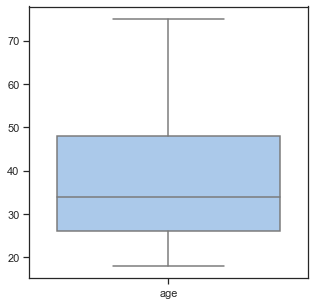

In [29]:
sns.set_theme(style="ticks", palette="pastel")
plt.figure (figsize=(5,5))
sns.boxplot (data=df_train)

#### Пропусков и выбросов нет

In [30]:
if normaltest(df_train['age'].astype(np.float32).values).pvalue>0.05:
    print ("Распределение СООТВЕТСТВУЕТ нормальному")
else:
    print ("Распределение НЕ СООТВЕТСТВУЕТ нормальному")

Распределение НЕ СООТВЕТСТВУЕТ нормальному


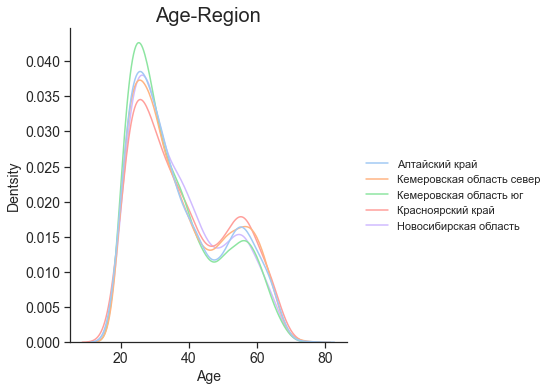

In [31]:
sns.displot(
    {
        "Алтайский край": df_train[df_train.region == 'Алтайский край'].age,
        "Кемеровская область север": df_train[df_train.region == 'Кемеровская область север'].age,
        "Кемеровская область юг": df_train[df_train.region == 'Кемеровская область юг'].age,
        "Красноярский край": df_train[df_train.region == 'Красноярский край'].age,
        "Новосибирская область":df_train[df_train.region == 'Новосибирская область'].age,
    },
    kind="kde",
    common_norm=False
)

plt.title('Age-Region', fontsize=20)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Dentsity', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

### Дату необходимо обработать

In [32]:
df_train['date_start'].value_counts()

30-Dec-2013    295
31-Dec-2013    208
27-Dec-2013    184
23-Dec-2013    180
26-Dec-2013    170
              ... 
17-Feb-2013      9
20-Jan-2013      7
27-Jan-2013      7
10-Feb-2013      7
02-Jan-2014      2
Name: date_start, Length: 365, dtype: int64

In [33]:
df_train['date_end'].value_counts()

13-Jan-2014    278
14-Jan-2014    201
09-Jan-2014    178
06-Jan-2014    176
10-Jan-2014    175
              ... 
14-Jan-2013      6
13-Jan-2013      5
10-Jan-2013      3
12-Jan-2013      3
09-Jan-2013      2
Name: date_end, Length: 373, dtype: int64

In [34]:
df_train['date_start'] = pd.to_datetime(df_train['date_start'], format="%d-%b-%Y")
df_train['date_end'] = pd.to_datetime(df_train['date_end'], format="%d-%b-%Y")

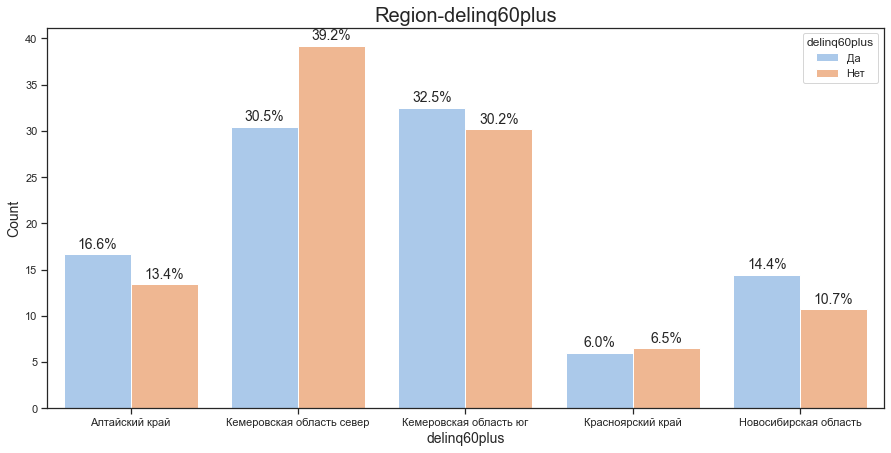

In [35]:
plt.figure(figsize=(15, 7))

educ_def = (df_train.groupby(['delinq60plus'])['region']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('region'))

ax = sns.barplot(x="region", y="percentage", hue="delinq60plus", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('Region-delinq60plus', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('delinq60plus', fontsize=14)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11);

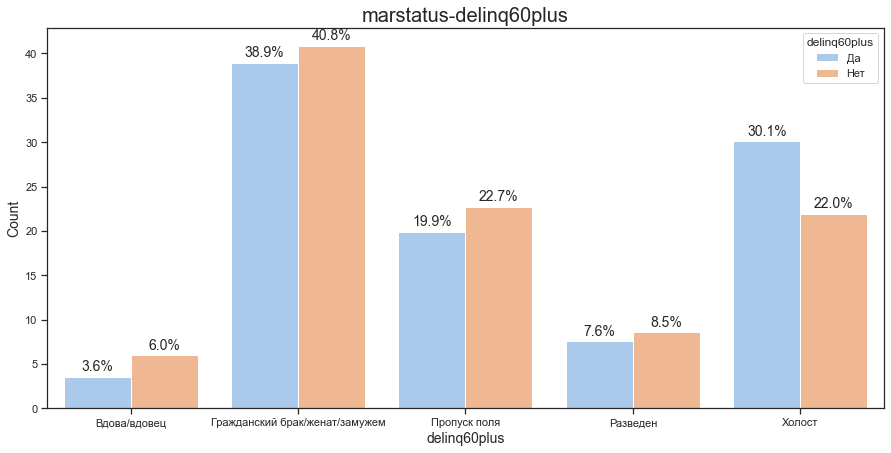

In [36]:
plt.figure(figsize=(15, 7))

educ_def = (df_train.groupby(['delinq60plus'])['marstatus']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('marstatus'))

ax = sns.barplot(x="marstatus", y="percentage", hue="delinq60plus", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('marstatus-delinq60plus', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('delinq60plus', fontsize=14)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11);

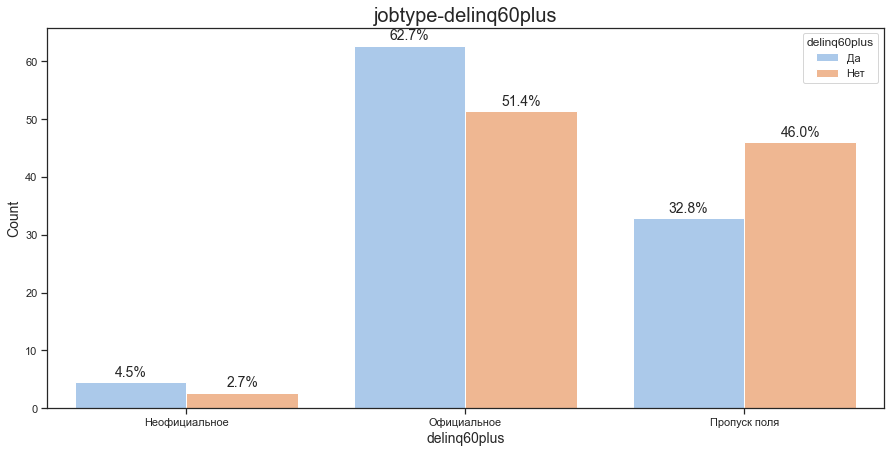

In [37]:
plt.figure(figsize=(15, 7))

educ_def = (df_train.groupby(['delinq60plus'])['jobtype']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('jobtype'))

ax = sns.barplot(x="jobtype", y="percentage", hue="delinq60plus", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('jobtype-delinq60plus', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('delinq60plus', fontsize=14)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11);

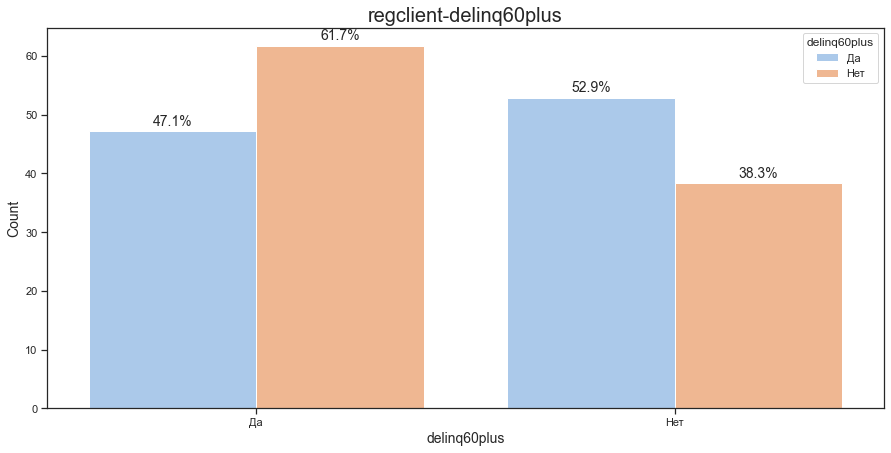

In [38]:
plt.figure(figsize=(15, 7))

educ_def = (df_train.groupby(['delinq60plus'])['regclient']
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values('regclient'))

ax = sns.barplot(x="regclient", y="percentage", hue="delinq60plus", data=educ_def)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()),  # координата xy
                ha='center',  # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points',  # точка смещения относительно координаты
                fontsize=14)

plt.title('regclient-delinq60plus', fontsize=20)
plt.ylabel('Count', fontsize=14)
plt.xlabel('delinq60plus', fontsize=14)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11);

In [39]:
df_train.describe(include=[object])

,gender,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
count,24573,24573,24573,24573,24573,24573,24573,24573,24573,24573
unique,2,3,6,5,2,3,5,3,3,2
top,Женский,Нет,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
freq,12704,12111,12537,9855,13787,13693,8807,12604,14721,15122


In [40]:
dm= pd.DataFrame(df_train,columns=['gender', 'age', 'auto', 'housing', 'marstatus', 'regclient', 'jobtype', 'region', 'credits', 'children', 'delinq60plus'])


In [41]:
dm.replace(to_replace = "Пропуск поля", value = np.nan, inplace=True)
dm.replace(to_replace = "Нет", value = 0, inplace=True)
dm.replace(to_replace = "Да", value = 1, inplace=True)

<AxesSubplot:>

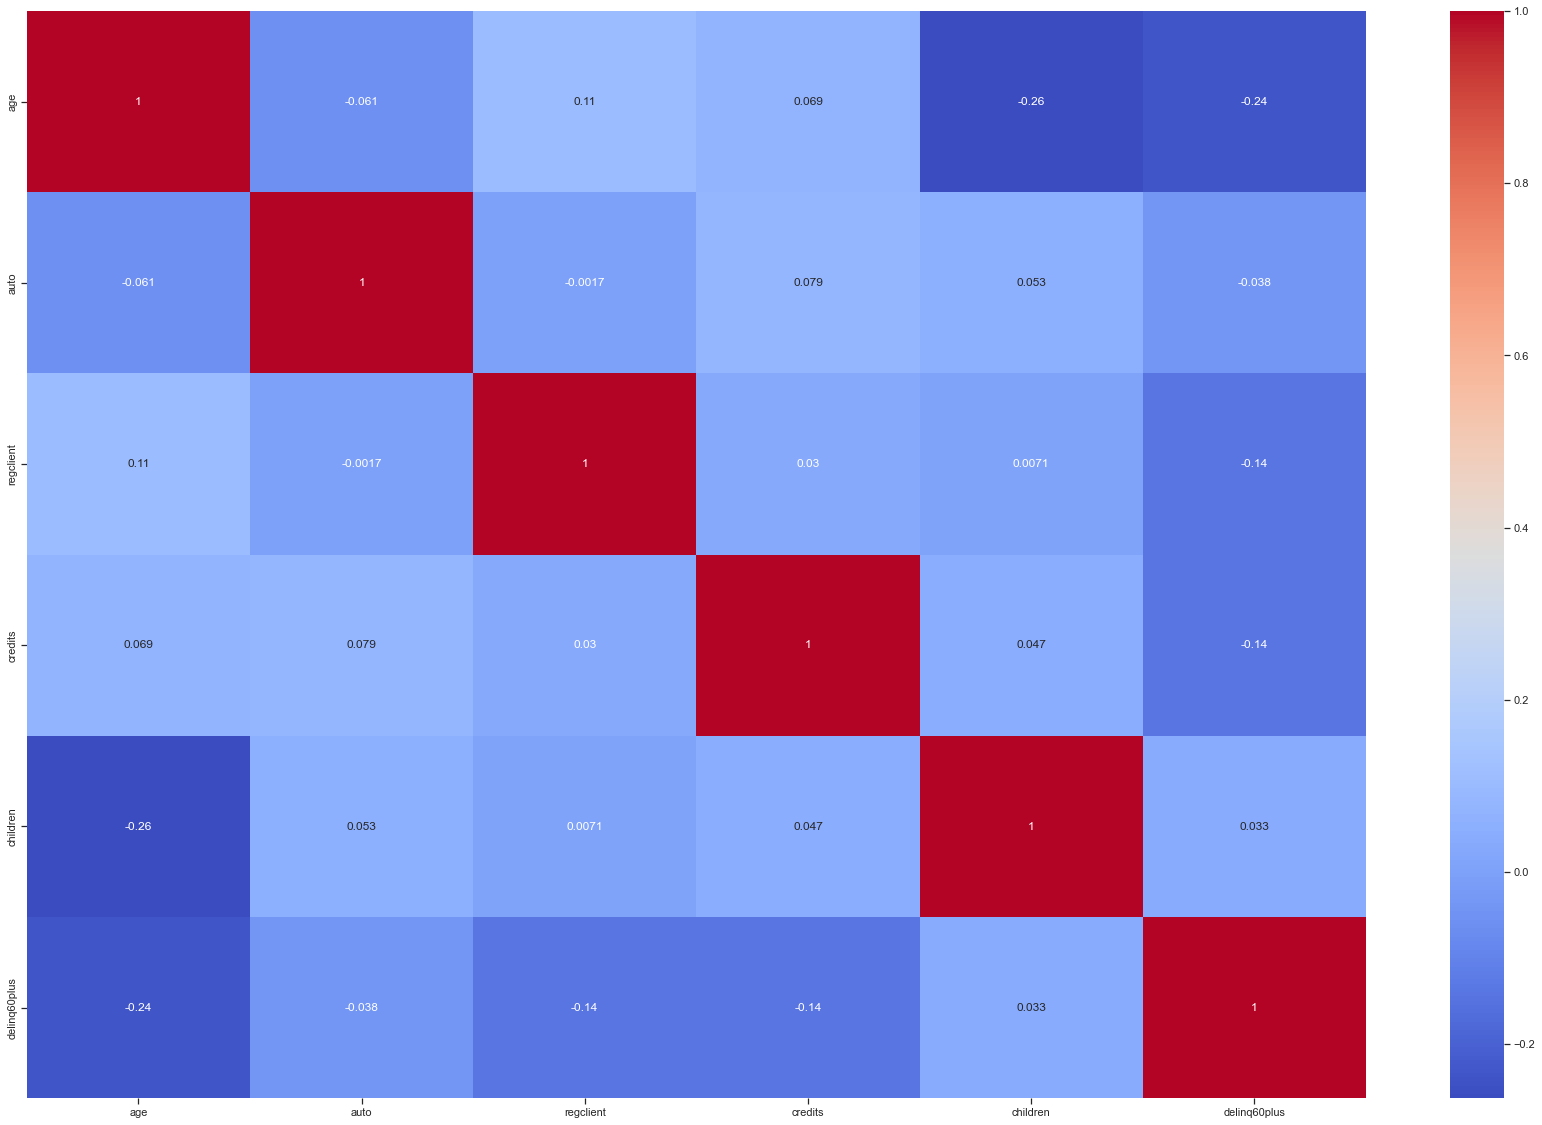

In [42]:
# есть небольшая обратная корреляция основного параматра с датами выдачи и погашения займа
plt.figure(figsize=(30,20))
sns.heatmap(dm.corr(), annot=True, cmap='coolwarm')

In [43]:
dm = pd.concat([dm,
           pd.get_dummies(dm['gender'], prefix='gender'),
           pd.get_dummies(dm['auto'], prefix='auto'),
           pd.get_dummies(dm['housing'], prefix='housing'),
           pd.get_dummies(dm['marstatus'], prefix='marstatus'),
           pd.get_dummies(dm['regclient'], prefix='regclient'),
           pd.get_dummies(dm['jobtype'], prefix='jobtype'), 
           pd.get_dummies(dm['region'], prefix='region'),
           pd.get_dummies(dm['credits'], prefix='credits'),
           pd.get_dummies(dm['children'], prefix='credits')], axis=1)

In [44]:
#Убираем замененные колонки
dm = dm.drop(['gender', 'age', 'auto', 'housing', 'marstatus', 'regclient', 'jobtype', 'region', 'credits', 'children'], axis=1)

In [45]:
y = dm['delinq60plus']
X = dm.drop(['delinq60plus'], axis=1)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)

In [47]:
ss=MinMaxScaler(feature_range=(-1,1))
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

In [48]:
rfc_scaled = RandomForestClassifier(max_depth=25) #стандартные параметры
rfc_scaled.fit(X_train_scaled,y_train)
rfc_scaled.score (X_test_scaled, y_test)

0.6273738469886055

In [50]:
# Модель RandomForest
forest = RandomForestClassifier(n_estimators=800, max_depth=17, 
                                random_state=2020, n_jobs=-1)

In [51]:
forest.fit(X_train, y_train);

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, forest.predict_proba(X_train)[:, 1])))
print('AUC на контрольной выборке: {:.3f}'.
      format(roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])))

AUC на обучающей выборке: 0.805
AUC на контрольной выборке: 0.610
